# Quantile SGD with q_init

Here we want to see how q_init will affect the quantile estimation.

## Set initial value of q

### Previous setting: initial value q fixed for all datasets and $\tau$ values
For the previous SGD quantile estimation, the first estimate of any $\tau$-quantile begins with a random default number q_r (usually 0). Specifically,
```python
def SGD (dataset, tau):
    q = 0                      # Here q=q_r=0, which is randomly chosen for all datasets and tau values
    for x in dataset:
        update_sgd(q,x)
    return q
```

### My idea: change q_init so it differs for different dataset and $\tau$ values
This time, q_init is chosen before the SGD algorithm. It will be chosen w.r.t. the first N_init of numbers, which will theoretically be more accurate than a randomly chosen q_init. So the code will be
```python
def SGD (dataset, tau):
    q_init = get_q_init(dataset, tau, N_init)         # q_init is chosen according to the dataset and tau
    q = q_init      
    for x in dataset:
        update_sgd(q,x)
    return q
```

## Mathmatical Theory Proof

Here we want to proof that for any distribution and $\tau$ values, the q_init has a higher possibility to be closer to the real quantile number than a randomly chosen q_r.

### Convertion to uniform distribution histograms by quantiles

q-quantiles are values that partition a finite set of values into q subsets of (nearly) equal sizes. (wiki). For example, the 4-quantiles devides a distribution into 4 subsets.

![Image from wiki](https://upload.wikimedia.org/wikipedia/commons/5/5e/Iqr_with_quantile.png)

This image shows probability density of a normal distribution, with quartiles shown. The area below the red curve is the same in the intervals $(-\infty,Q_1), (Q_1, Q_2), (Q_2, Q_3)$, and $(Q_3, +\infty)$. 

Here we rename the distribution quantiles $Q_1, Q_2, Q_3$ to $\tau$-quantiles ($\tau = 0.25, 0.5, 0.75$), so they are now $Q_{0.25}, Q_{0.5}, Q_{0.75}$

This can be shown in histograms like "uniform distribution": 
![Image for 4-quantiles](4_quantile.png)

From this we can see that the probability of a random number generated from the distribution is the same for all four histograms. 

Generally, if the $q$ for $q$-quantiles is infinitely large, there will be infinite histograms for any distribution. This is how we convert a distribution to a "uniform distribution" by quantiles. And from this we can see, the possibility of a random sample falls in the interval $(Q_{\tau_1}, Q_{\tau_2})$ is $\tau_2-\tau_1$ (where $Q_\tau$ is the $\tau$-quantile).

### Comparison of q_r and q_init

Let $Q_{\tau}$ represents the real $\tau$-quantile value of the distribution

In a uniform distribution histogram, let range $A_\tau$ be the interval of numbers that's close to $Q_\tau$. Specifically,

$$
  A_\tau =
    \begin{cases}
      (-\infty, Q_{\tau +0.05}) & \text{if $\tau < 0.05$}\\
      (Q_{\tau -0.05}, Q_{\tau +0.05}) & \text{if $\tau \geq 0.05$ and $\tau \leq 0.95$}\\
      (-\tau + 1.05, +\infty) & \text{if $\tau > 0.95$}
    \end{cases}       
$$
To simplify it, we say $A_\tau = (Q_{\tau^{-}}, Q_{\tau^{+}})$, and it is obvious that $Q_{\tau^{-}}< Q_{\tau} < Q_{\tau^{+}}$

Here we want to show that $Pr(q_{init} \in A_\tau) \geq Pr(q_r \in A_\tau)$

![no_border](100_quantile_edited.png)
The above image shows $\tau \geq 0.05$ and $\tau \leq 0.95$

![no_border](100_quantile_border.png)
The above image shows $\tau < 0.05$

#### Proof
$$
Pr(q_r \in A_\tau) = 
    \begin{cases}
      \tau +0.05 &   \text{($0 < \tau < 0.05$)}\\
      0.1 &          \text{($0.05 \leq \tau \leq 0.95$)}\\
      -\tau + 1.05 & \text{($ 0.95 < \tau < 1$)}
    \end{cases}  
$$
![no_border](q_init_calculation.png)

### Code and results 

In [130]:
import math

def nCr(n,r):
    f = math.factorial
    return f(n) / f(r) / f(n-r)

def exact_x_times(n, x, p):
    return nCr(n,x) * ((p)**x) * ((1-p)**(n-x))

def at_most_x_times(n, x, p):
#     print ('at_most_x_times', n, x, p)
    l = [exact_x_times(n, i, p) for i in range(x+1)]
    return sum(l)



def compute_prob_q_init(n, tau):
    k = round(tau * n)
    p1, p2 = 1, 1
    if tau > 0.05:
#         print ('p1:', k, tau-0.05)
        p1 = at_most_x_times(n, k, tau-0.05)
#         print ('p1:', p1)
    if tau < 0.95:
#         print ('p2:', n-k, 1-(tau+0.05))
        p2 = at_most_x_times(n, n-k, 1-(tau+0.05))
#         print ('p2', p2)
    return p1 * p2

In [192]:
%matplotlib inline  
import numpy as np
import matplotlib.pyplot as plt

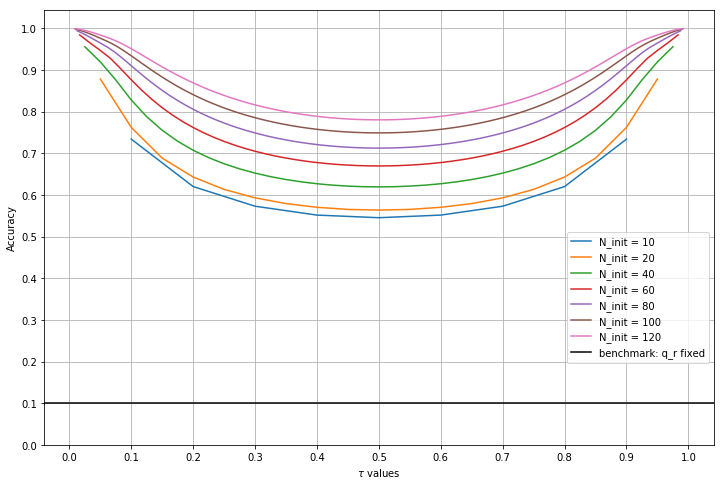

In [196]:
# at_most_x_times(10, 10, 0.9)
# at_most_x_times(10, 3, 0.1)
# a = compute_prob_q_init(100, 0.95)
# https://stattrek.com/online-calculator/binomial.aspx

plt.figure(figsize=(12,8))
N_inits = [10, 20, 40, 60, 80, 100, 120]
for idx, n in enumerate(N_inits):
    y = [compute_prob_q_init(n, (i+1)/n) for i in range(n-1)]
    x = [((i+1)/n) for i in range(n-1)]
    plt.plot(x,y, label = ('N_init = '+ str(n)))
plt.axhline(y = 0.1, color = 'black', label='benchmark: q_r fixed')
plt.ylabel('Accuracy')
plt.xlabel((r'$\tau$' + ' values'))
plt.xticks(np.arange(0, 1.1, step=0.1))
plt.yticks(np.arange(0, 1.1, step=0.1))
plt.legend(loc='upper right', bbox_to_anchor=(1, 0.5))
plt.grid(True)
# plt.set_title('N_init and fdfds')

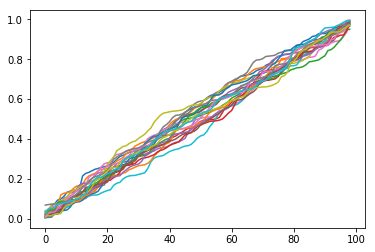

In [198]:
# test with real distribution
N_init = 1000
trails = 20
def test_q_init(N_init, trails):
    q_inits_all = np.zeros((trails, N_init-1))
    for n in range(trails):
        datastream = np.random.uniform(0,1,N_init)
        q_inits = np.zeros(N_init-1)
        for i in range(N_init-1):
            tau = (i+1)*100/N_init
            q_inits[i] = np.percentile(datastream, tau)
        plt.plot(q_inits)
        q_inits_all[n] = q_inits
    
test_q_init(100, 20)
# test_q_init(100, 20)
# q_init_mean = np.mean(q_inits_all, axis=0)
# plt.plot(q_init_mean)

In [199]:
# plt.figure(figsize=(12,5))
# # ax = plt.subplot(121)
# x = np.append(np.arange(99)*0.01, [1])
# weights = np.array([0.01]*100)
# plt.hist(x, bins=100, weights=weights,  edgecolor='darkgreen', linewidth=1, color='salmon')
# plt.locator_params(axis='y', nbins=6)
# plt.locator_params(axis='x', nbins=5)
# plt.xticks([0, 0.02, 0.07, 1],
#           [r'$-\infty$     ', r'    $Q_{\tau}$', r'    $Q_{\tau^{+}}$', r'$+\infty$'], size='xx-large')
# plt.ylabel('Probability')
# plt.xlabel('Value')
# # plt.show()
# plt.savefig("100_quantile.png")